In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network

## Template 05
## Working with PyTorch - Flowers DataSet

<img src='../../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

from collections.abc import Callable
from typing import Literal


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset , random_split
from torchsummary import summary
from torchvision import datasets, transforms
from torchvision.transforms import v2
#from utils.helper import fn_plot_torch_hist

In [3]:

def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();


def fn_plot_torch_hist(hist_df):
    
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset=y2)
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot
        
    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()



In [4]:
###----------------------
### Some basic parameters
###----------------------

inpDir = 'D:\DNN\input' # location where input data is stored
outDir = '../../output' # location to store outputs
modelDir = '../models'
subDir = 'flower_photos'
altName = 'torch_all_in'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results
np.random.seed(RANDOM_STATE)

EPOCHS = 200 # number of epochs

BATCH_SIZE = 16
TRAIN_SIZE = int(184*BATCH_SIZE )  ###pay attention when changing BATCH_SIZE
ALPHA = 0.001 # learning rate

TEST_SIZE = 0.2

# Input Image size
IMG_HEIGHT = 188
IMG_WIDTH = 188

# for early stopping 
PATIENCE = 20
LR_FACTOR = 0.1
LR_PATIENCE = 10

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 4),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [5]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## All about CUDA

In [6]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cpu device


## Read Flowers data set

In [7]:
###---------------
### Transformation
###---------------

transform = v2.Compose([
    v2.Resize(IMG_HEIGHT),
    v2.RandomRotation(degrees=(-45,45)),
    v2.CenterCrop(IMG_HEIGHT),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32 , scale = True),
    v2.Normalize( mean = [0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  
])

data_dir = os.path.join(inpDir, subDir)

dataset = datasets.ImageFolder(data_dir, transform=transform)

In [8]:
image, label = next(iter(dataset))
image.shape, label

(torch.Size([3, 188, 188]), 0)

In [9]:
dataset_size = len(dataset)

indices = torch.randperm(dataset_size).tolist()
#indices

# pick up indices up to test_size
train_dataset = torch.utils.data.Subset(dataset,indices[:TRAIN_SIZE])

# pickup from test_size
test_dataset = torch.utils.data.Subset(dataset,indices[TRAIN_SIZE:])

len(train_dataset) , len(test_dataset)

(2944, 726)

In [10]:
class_names = {count : nclass for count , nclass in enumerate(train_dataset.dataset.classes)}
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [11]:
numClasses = len(class_names)
numClasses

5

In [12]:
next(iter(train_dataset))[0].shape

torch.Size([3, 188, 188])

## Data Loader

In [13]:
#torch.utils.data.DataLoader?

In [14]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               shuffle= True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               shuffle= True)


trainSteps = len(train_dataloader.dataset) // BATCH_SIZE

testSteps = len(test_dataloader.dataset) // BATCH_SIZE

print (trainSteps, testSteps)

184 45


In [15]:
def fn_showImages(img, ax):

    img = img.numpy().transpose((1,2,0)) 

    means = np.array([0.485, 0.456, 0.406])
    
    stds = np.array([0.229, 0.224, 0.225])
    
    img = stds * img + means
    
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.axis('off')

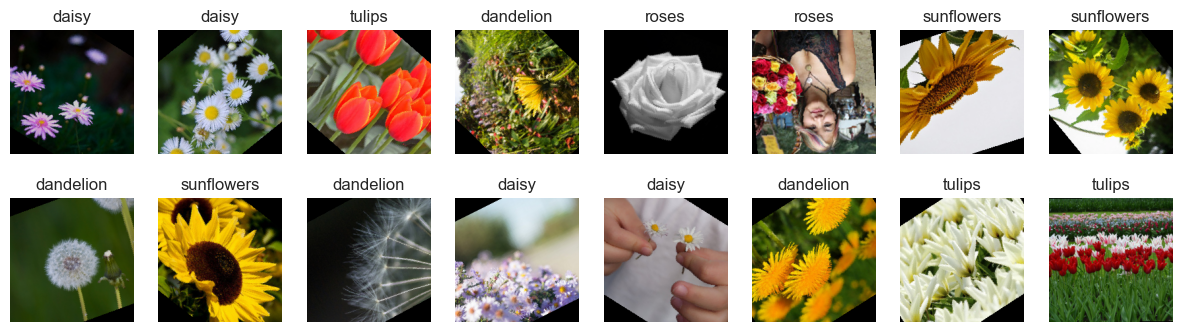

In [16]:
images, labels =next(iter(train_dataloader))

#print (images.shape, labels.shape)

fig = plt.figure()

for i in range (BATCH_SIZE):

    ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)
    
    fn_showImages(images[i], ax)

    ax.set_title(class_names[labels[i].item()])

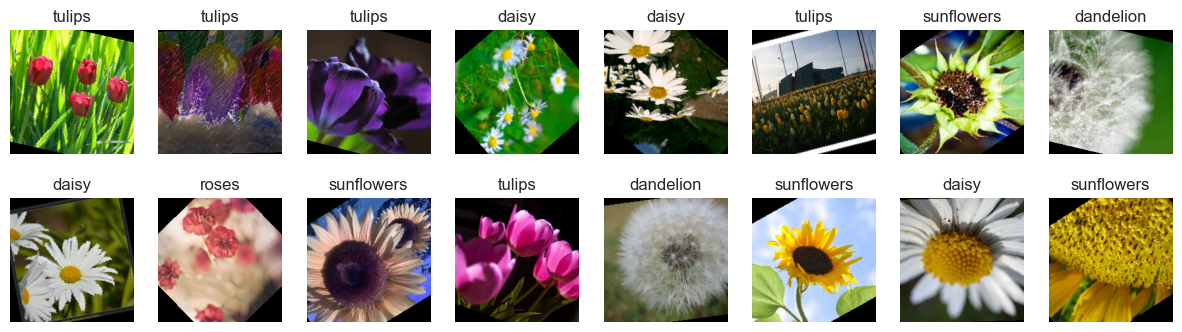

In [17]:
images, labels =next(iter(test_dataloader))

#print (images.shape, labels.shape)

fig = plt.figure()

for i in range (BATCH_SIZE):

    ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)
    
    fn_showImages(images[i], ax)

    ax.set_title(class_names[labels[i].item()])

In [18]:
class AlexNet(nn.Module):
    def __init__(self, numChannels ,  classes) :
        super(AlexNet , self).__init__()

        dor1 = 0.3
        dor2 = 0.3
        dor3 = 0.4
        dor4 = 0.5
        dor5 = 0.5

        ##set1

        out_channels1 = 32

        self.conv1 = nn.Conv2d(in_channels=numChannels ,
                               out_channels= out_channels1,
                               kernel_size= (3,3))
        
        self.bn1 = nn.BatchNorm2d(out_channels1)

        self.actv1 = nn.LeakyReLU()

        self.maxpool1 = nn.MaxPool2d(kernel_size=(4,4), stride=(4,4))

        self.dropout1 = nn.Dropout(p=dor1)

        ##set2

        out_channels2 = 64

        self.conv2 = nn.Conv2d(in_channels=out_channels1 ,
                               out_channels= out_channels2 ,
                               kernel_size= (3,3))
      
        self.bn2 = nn.BatchNorm2d(out_channels2)

        self.actv2 = nn.LeakyReLU()

        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.dropout2 = nn.Dropout(p=dor2)

        ##set3

        out_channels3 = 128

        self.conv3 = nn.Conv2d(in_channels=out_channels2 ,
                               out_channels= out_channels3,
                               kernel_size= (3,3))
      
        self.bn3 = nn.BatchNorm2d(out_channels3)

        self.actv3 = nn.LeakyReLU()

        self.maxpool3 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.dropout3 = nn.Dropout(p=dor3)

        ##set4

        out_channels4 = 256

        self.conv4 = nn.Conv2d(in_channels=out_channels3 ,
                               out_channels= out_channels4,
                               kernel_size= (3,3))
      
        self.bn4 = nn.BatchNorm2d(out_channels4)

        self.actv4 = nn.LeakyReLU()

        self.maxpool4 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.dropout4 = nn.Dropout(p=dor4)

        ##Head

        out_channels5 = 512

        self.fc1 = nn.Linear(in_features=  4 * 4* out_channels4 ,
                               out_features= out_channels5 )
      
        self.bn5 = nn.BatchNorm1d(out_channels5)

        self.actv5 = nn.LeakyReLU()

        self.dropout5 = nn.Dropout(p=dor5)

        #fully connected layer

        self.fc2 = nn.Linear ( in_features= out_channels5 ,
                              out_features=classes)
        
        self.logSoftmax = nn.LogSoftmax(dim =1)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.actv1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.actv2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.actv3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.actv4(x)
        x = self.maxpool4(x)
        x = self.dropout4(x)

        x = torch.flatten(x,1)

        x = self.fc1(x)
        x = self.bn5(x)
        x = self.actv5(x)
        x = self.dropout5(x)

        x = self.fc2(x)

        return self.logSoftmax(x)





In [19]:
numChannels = 3

model = AlexNet(numChannels=numChannels , classes=numClasses).to(device)

summary(model , (numChannels , IMG_HEIGHT , IMG_WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 186, 186]             896
       BatchNorm2d-2         [-1, 32, 186, 186]              64
         LeakyReLU-3         [-1, 32, 186, 186]               0
         MaxPool2d-4           [-1, 32, 46, 46]               0
           Dropout-5           [-1, 32, 46, 46]               0
            Conv2d-6           [-1, 64, 44, 44]          18,496
       BatchNorm2d-7           [-1, 64, 44, 44]             128
         LeakyReLU-8           [-1, 64, 44, 44]               0
         MaxPool2d-9           [-1, 64, 22, 22]               0
          Dropout-10           [-1, 64, 22, 22]               0
           Conv2d-11          [-1, 128, 20, 20]          73,856
      BatchNorm2d-12          [-1, 128, 20, 20]             256
        LeakyReLU-13          [-1, 128, 20, 20]               0
        MaxPool2d-14          [-1, 128,

In [20]:
import time
optimizer=torch.optim.AdamW(model.parameters() , lr = ALPHA)

loss_fn = nn.CrossEntropyLoss()

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer ,
                                                          factor=LR_FACTOR,
                                                          patience=PATIENCE,
                                                          min_lr=1e-5)

H = {
    'Epoch'       : [] ,
    'Train Loss'  : [] ,
    'Test Loss'   : [] ,
    'Train Acc'   : [] ,
    'Test Acc'    : [] ,
    'Alpha'       : [] ,
    'Patience'    : [] 
}

print('done')

done


In [21]:
minLoss = float('inf')

savePath = os.path.join(modelDir , subDir , 'flowers.pth')
for epoch in range(EPOCHS):

    epochStart = time.time()

    train_loss = 0.0
    train_Acc = 0.0
    for i , data in enumerate(train_dataloader):
        model.train()

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        preds = torch.argmax(outputs , dim=1)
        batch_loss = loss_fn(outputs , labels)
        batch_acc = accuracy_score(labels.cpu().numpy() , preds.cpu().numpy())

        batch_loss.backward()
        optimizer.step()

        train_loss += batch_loss.item() * inputs.size(0)
        train_Acc += batch_acc * inputs.size(0)

    train_loss /= len(train_dataset)
    train_Acc /= len(train_dataset)

    H['Train Loss'].append(train_loss)
    H["Train Acc"].append(train_Acc)

    test_loss = 0.0 
    test_acc = 0.0

    with torch.no_grad():
        model.eval() 

        for  data in test_dataloader:

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            preds = torch.argmax(outputs , dim=1)

            batch_loss = loss_fn(outputs , labels)
            batch_acc = accuracy_score(labels.cpu().numpy() , preds.cpu().numpy())

            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc * inputs.size(0)

        test_loss /= len(test_dataset)
        test_acc /= len(test_dataset)

        H['Test Loss'].append(test_loss)
        H["Test Acc"].append(test_acc)

    H['Epoch'].append(epoch)

    lr_scheduler.step(test_loss)

    if test_loss <= minLoss:

        minLoss = test_loss
        counter = 0
        torch.save({'epoch':epoch +1,
                   'model_state_dict' : model.state_dict() , 
                   'optimizer_state_dict' : optimizer.state_dict() ,
                   'loss' : loss_fn , } ,savePath)
    else:
        counter += 1
    if counter > PATIENCE:
        break

    curr_alpha = lr_scheduler.get_last_lr()[0]
    H['Alpha'].append(curr_alpha)

    H['Patience'].append(counter)

    if epoch%2 == 0:
        print(f'Epoch : {epoch:3d}/{EPOCHS:3d} ',end = '')
        print(f'Loss : {train_loss:.6f}/{test_loss:.6f} , Accuracy: {train_Acc:.4f}/{test_acc:.4f}',end = '')
        print(f'Alpha : {curr_alpha:.6f}, ES : {counter:2d} ',end = '')
        print(f"Epoch time: {time.time() - epochStart:.2f}Sec")
    

Epoch :   0/200 Loss : 1.307298/1.513069 , Accuracy: 0.4511/0.3320Alpha : 0.001000, ES :  0 Epoch time: 83.49Sec
Epoch :   2/200 Loss : 1.041354/1.365351 , Accuracy: 0.5642/0.4477Alpha : 0.001000, ES :  1 Epoch time: 82.91Sec
Epoch :   4/200 Loss : 0.938674/1.033082 , Accuracy: 0.6179/0.5868Alpha : 0.001000, ES :  1 Epoch time: 81.70Sec
Epoch :   6/200 Loss : 0.883861/1.040838 , Accuracy: 0.6491/0.5716Alpha : 0.001000, ES :  3 Epoch time: 81.64Sec
Epoch :   8/200 Loss : 0.838756/0.813679 , Accuracy: 0.6529/0.6736Alpha : 0.001000, ES :  0 Epoch time: 81.67Sec
Epoch :  10/200 Loss : 0.825072/0.909871 , Accuracy: 0.6793/0.6501Alpha : 0.001000, ES :  2 Epoch time: 81.87Sec
Epoch :  12/200 Loss : 0.802794/0.849747 , Accuracy: 0.6892/0.6791Alpha : 0.001000, ES :  4 Epoch time: 81.68Sec
Epoch :  14/200 Loss : 0.779069/0.806449 , Accuracy: 0.6923/0.6832Alpha : 0.001000, ES :  1 Epoch time: 81.60Sec
Epoch :  16/200 Loss : 0.745800/0.757690 , Accuracy: 0.7130/0.7121Alpha : 0.001000, ES :  0 Epoc

In [24]:
loss_df = pd.DataFrame({'Epoch ' : epoch, 'Loss ' : train_loss / test_loss, 'Accuracy' : train_Acc/ test_acc})
loss_df.head()

ValueError: If using all scalar values, you must pass an index

In [ ]:
fn_plot_torch_hist(loss_df)